# imports 

In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

# 공식홈페이지 예제

## data 

In [7]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

## RecurrentGCN

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

## Learn

In [9]:
# from tqdm import tqdm

# model = RecurrentGCN(node_features=14, filters=32)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# model.train()

# for epoch in tqdm(range(50)):
#     for time, snapshot in enumerate(train_dataset):
#         y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
#         cost = torch.mean((y_hat-snapshot.y)**2)
#         cost.backward()
#         optimizer.step()
#         optimizer.zero_grad()

In [10]:
model = RecurrentGCN(node_features=14, filters=32)
model.train()

RecurrentGCN(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(14, 32, K=2, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_r): ChebConv(14, 32, K=2, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_h): ChebConv(14, 32, K=2, normalization=sym)
    (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
for s in train_dataset:
    print((s.y-model(s.x,s.edge_index,s.edge_attr)).shape)

torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])
torch.Size([1068, 1068])


## 예제의 차원 조사 

In [83]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [84]:
_x.shape

torch.Size([1068, 14])

- 1068: number of nodes // 1068개의 노드가 있음 
- 14: number of features // 하나의 노드에 맵핑된 차원의수 

In [85]:
_edge_index.shape

torch.Size([2, 27079])

In [86]:
_edge_attr.shape

torch.Size([27079])

In [87]:
_y.shape

torch.Size([1068])

- 1068: number of nodes

In [88]:
_x.shape

torch.Size([1068, 14])

# 우리예제

In [211]:
T = 100 
N = 2 # number of nodes 
E = np.array([[0,1],[1,0]]).T
V = np.array([1,2])
AMP = np.array([3,2,1,2.2])
t = np.arange(0,T)/T*10
node_features = 1

In [212]:
#f = np.stack([a*np.sin(2*t**2/1000)+np.random.normal(loc=0,scale=0.2,size=T) for a in AMP],axis=1).reshape(T,N,node_features)
#f = torch.tensor(f).float()

In [213]:
x = 0.8*np.sin(2*t)+0.5*np.sin(5*t)+0.1*np.sin(8*t)
y = x.copy()
for i in range(2,T):
    y[i] = 0.35*x[i-1] - 0.15*x[i-2] + 0.5*np.cos(0.5*t[i]) 

In [214]:
f = torch.tensor(np.stack([x,y]).T.reshape(100,2,1)).float()

In [215]:
X = f[:98,:,:]
y = f[2:,:,:]

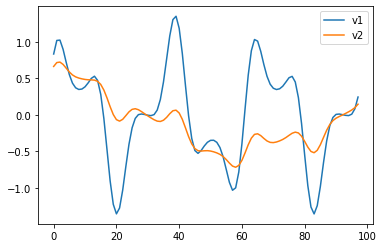

In [216]:
plt.plot(y[:,0,0],label="v1")
plt.plot(y[:,1,0],label="v2")
#plt.plot(y[:,2,0],label="v3")
#plt.plot(y[:,3,0],label="v4")
plt.legend()

In [217]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1]),dtype=torch.float32)

In [218]:
_ee = enumerate(zip(X,y))

In [266]:
from tqdm import tqdm

model = RecurrentGCN(node_features=1, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


In [243]:
y_hat,yt

(tensor([[0.0142],
         [0.0518]], grad_fn=<AddmmBackward0>),
 tensor([[0.2432],
         [0.1453]]))

In [221]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

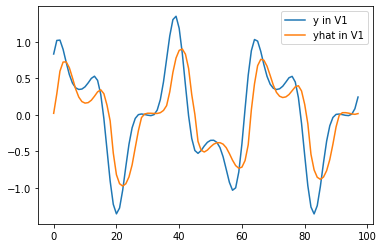

In [222]:
plt.plot(y[:,0,0],label="y in V1")
plt.plot(yhat[:,0,0],label="yhat in V1")
plt.legend()

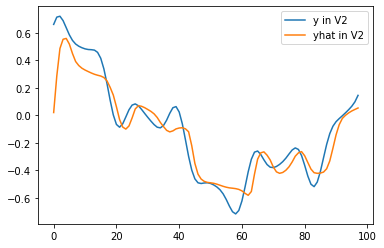

In [223]:
plt.plot(y[:,1,0],label="y in V2")
plt.plot(yhat[:,1,0],label="yhat in V2")
plt.legend()